In [1]:
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import *
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.initializers import glorot_uniform

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}") 
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(tf.config.list_physical_devices('GPU'))


Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Python 3.7.7 (default, Mar 23 2020, 23:19:08) [MSC v.1916 64 bit (AMD64)]
Pandas 1.0.3
Scikit-Learn 0.22.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
num_classes = 7
img_rows,img_cols = 48,48
batch_size = 32
epochs = 25

with open("datasets/fer2013/fer2013.csv") as f:
  content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
      print("", end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

number of instances:  35888
instance length:  2304
28709 train samples
3589 test samples


In [3]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_bname_base  = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3= filters
    
    X_shortcut = X
    
    X = Conv2D(F1, (1,1), (1,1), padding= 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = -1, name = bn_bname_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (f, f), (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = -1, name = bn_bname_base + '2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F3, (1, 1), (1, 1), padding ='valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = -1, name = bn_bname_base + '2c')(X)
    
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

In [4]:
def convolutional_block(X, f, filters, stage, block, s =2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis=-1, name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+'2c', kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=-1, name = bn_name_base + '2c')(X)
    
    X_shortcut = Conv2D(F3, (1,1), strides=(s,s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization(axis=-1, name=bn_name_base+'1')(X_shortcut)
    
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X


In [5]:
def ResNet50(input_shape, classes):
    x_input = Input(input_shape)
    
    X = ZeroPadding2D((3,3))(x_input)
    
    X = Conv2D(64, (3,3), (1,1), name='conv1', kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis=-1, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters = [128,128,512], stage = 3, s=2, block = 'a')
    X = identity_block(X, 3, [128,128,512], stage = 3,block ='b')
    X = identity_block(X, 3, [128,128,512], stage = 3,block ='c')
    X = identity_block(X, 3, [128,128,512], stage = 3,block ='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X,  3, [256,256,1024], s=2, stage = 4,block = 'a')
    X = identity_block(X, 3, [256,256,1024], stage = 4,block='b')
    X = identity_block(X, 3, [256,256,1024], stage = 4,block='c')
    X = identity_block(X, 3, [256,256,1024], stage = 4,block='d')
    X = identity_block(X, 3, [256,256,1024], stage = 4,block='e')
    X = identity_block(X, 3, [256,256,1024], stage = 4,block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, 3, [512,512,2048], s = 2,stage = 5,block='a')
    X = identity_block(X, 3, [512,512,2048], stage = 5,block = 'b')
    X = identity_block(X, 3, [512,512,2048], stage = 5,block = 'c')
    
    X = AveragePooling2D((2,2), name = 'avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name = 'fc' + str(classes), kernel_initializer=glorot_uniform())(X)

    model = Model(inputs = x_input, outputs = X, name = 'ResNet50')
    return model

In [30]:
model = ResNet50((48,48,1), num_classes)

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
print ("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 28709
number of test examples = 3589
X_train shape: (28709, 48, 48, 1)
Y_train shape: (28709, 7)
X_test shape: (3589, 48, 48, 1)
Y_test shape: (3589, 7)


In [34]:
model.fit(x_train, y_train, epochs = 18, batch_size = 32) #model has been trained for a total of 20 epochs

Train on 28709 samples
Epoch 1/18
28709/28709 [==============================] - 97s 3ms/sample - loss: 1.8187 - accuracy: 0.3429

In [35]:
model.save('ResNet50.h5')

In [6]:
model = models.load_model('ResNet50.h5')
# Trained the model only once as it took a lot of time to train 20 epochs, 2 were done at first to see how much much
# time one epoch takes
preds = model.evaluate(x_test, y_test)
print('Loss: ' + str(preds[0]))
print('Accuracy: ' + str(preds[1]))   #Will try to Apply L2 or Droupout to make this better


3589/3589 [==============================] - 9s 2ms/sample - loss: 2.0871 - accuracy: 0.5807

My Image shape:  (1, 48, 48, 1)
scared


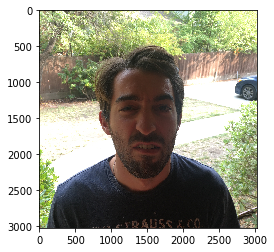

In [8]:
img_path = 'images/my_image.jpg'
EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised",
 "neutral"]
img = load_img(img_path, grayscale=True, target_size=(48,48))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255
print('My Image shape: ', x.shape)
image = plt.imread(img_path)
plt.imshow(image)
predictions = model.predict(x)
print(EMOTIONS[np.argmax(predictions)])


